Hello **Everyone** !  
Welcome to the **second part of Day 2** of our AI pool !  
This afternoon, we will explore how to make an AI model smarter by giving it access to external knowledge.  

Our goal : build a system that can answer questions about **your own documents** (PDFs, texts, etc.) with accurate information.  
Does that sound useful ? Let's dive in !

**But wait... why do we need this ?**

Remember this morning ? We fine-tuned a model to give us false capitals. The model "learned" these false facts.  
But there is a problem : **what if the information changes ?** What if we have thousands of documents that update every day ?

Fine-tuning every time is expensive and slow. We need a smarter approach : **RAG** (Retrieval Augmented Generation).  

Think of it like this :
- **Fine-tuning** = Teaching a student new facts by heart (slow, expensive)
- **RAG** = Giving the student access to a library and teaching them how to search (fast, flexible)

But before building RAG, we need to understand **embeddings** - the magic that makes search work !

# **I/ Understanding Embeddings**

### **What is an Embedding ?**

An embedding is a way to represent text (or images, audio...) as a **list of numbers** (a vector).  

Imagine you want to organize books in a library. Instead of organizing them alphabetically, you organize them by **meaning** :
- Books about cooking are close together
- Books about space are close together
- A book about "cooking in space" would be somewhere in between

Embeddings do exactly this : texts with similar meanings have similar numbers (vectors that are "close" in space).

**Example :**
- "I love pizza" → [0.2, 0.8, 0.1, ...]
- "Pizza is my favorite food" → [0.21, 0.79, 0.12, ...] (very similar)
- "The weather is nice" → [0.9, 0.1, 0.7, ...] (very different)

### ***1/ Setup: Install the necessary packages***

In [3]:
%pip install sentence-transformers chromadb numpy

Note: you may need to restart the kernel to use updated packages.


### ***2/ Create your first embedding***

We will use a pre-trained model from HuggingFace to create embeddings.  
The model `all-MiniLM-L6-v2` is small, fast, and works great for most use cases.

**Documentation :** https://www.sbert.net/docs/package_reference/sentence_transformer/SentenceTransformer.html

In [31]:
from sentence_transformers import SentenceTransformer

# TODO: Load the embedding model 'all-MiniLM-L6-v2'
embedding_model = SentenceTransformer(model_name_or_path='all-MiniLM-L6-v2')

text = "I love artificial intelligence"

# TODO: Create the embedding
embedding = embedding_model.encode(text)

print(f"Embedding created.")
print(f"Embedding dimension: {len(embedding)}")
print(f"First 10 values: {embedding[:10]}")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding created.
Embedding dimension: 384
First 10 values: [-0.02613595 -0.06418522  0.05793433 -0.02276829  0.03993453 -0.06943273
  0.05096799  0.02811378  0.05693001  0.04834886]


### ***3/ Measure similarity between texts***

Now comes the magic. We can measure how similar two texts are by comparing their embeddings.  
We use **cosine similarity** : a value between -1 and 1, where 1 means "identical meaning".

**Documentation :** https://www.sbert.net/docs/package_reference/util.html

**Your task :** Complete the code to calculate similarity between sentences.

In [42]:
from sentence_transformers import util

sentences = [
    "I love programming in Python",
    "Python is my favorite programming language",
    "The weather is beautiful today",
    "I enjoy coding and building software"
]

# TODO: Create embeddings for all sentences
embeddings = embedding_model.encode(sentences, convert_to_tensor=True)

print("Similarity with 'I love programming in Python':\n")

for i, sentence in enumerate(sentences):
    # TODO: Calculate cosine similarity between first embedding and current one
    similarity = util.cos_sim(embeddings[0], embeddings[i]).item()
    print(f"  \"{sentence}\"")
    print(f"  → Similarity: {similarity:.4f}\n")

Similarity with 'I love programming in Python':

  "I love programming in Python"
  → Similarity: 1.0000

  "Python is my favorite programming language"
  → Similarity: 0.8774

  "The weather is beautiful today"
  → Similarity: 0.0661

  "I enjoy coding and building software"
  → Similarity: 0.5893



**Question :** Which sentences have the highest similarity ? Does it make sense to you ?  
Take a moment to analyze the results before continuing.

### ***4/ Visualize embeddings (bonus)***

Embeddings have 384 dimensions - impossible to visualize directly.  
We can use **dimensionality reduction** to project them into 2D and see how texts are organized.

**Documentation :** https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

This is optional but helps understand how embeddings work.

Note: you may need to restart the kernel to use updated packages.


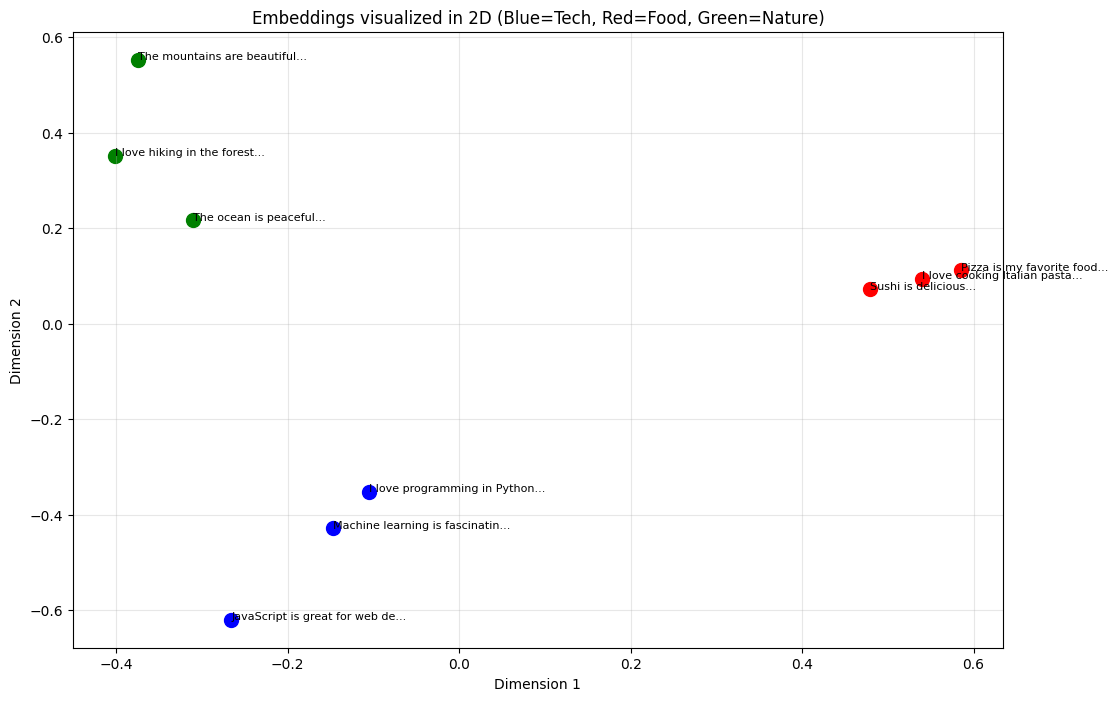


Notice how similar topics cluster together.


In [51]:
%pip install matplotlib scikit-learn

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

texts = [
    # Tech topic
    "I love programming in Python",
    "JavaScript is great for web development",
    "Machine learning is fascinating",
    # Food topic  
    "Pizza is my favorite food",
    "I love cooking Italian pasta",
    "Sushi is delicious",
    # Nature topic
    "The mountains are beautiful",
    "I love hiking in the forest",
    "The ocean is peaceful"
]

# TODO: Create embeddings for all texts
text_embeddings = embedding_model.encode(texts, convert_to_tensor=True)

# TODO: Reduce to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(text_embeddings)

plt.figure(figsize=(12, 8))
colors = ['blue', 'blue', 'blue', 'red', 'red', 'red', 'green', 'green', 'green']

for i, (x, y) in enumerate(embeddings_2d):
    plt.scatter(x, y, c=colors[i], s=100)
    plt.annotate(texts[i][:30] + "...", (x, y), fontsize=8)

plt.title("Embeddings visualized in 2D (Blue=Tech, Red=Food, Green=Nature)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True, alpha=0.3)
plt.show()

print("\nNotice how similar topics cluster together.")

# **II/ Building a Vector Database**

Now that we understand embeddings, we need a place to **store** them efficiently.  

A **vector database** is like a regular database, but optimized for :
- Storing embeddings (lists of numbers)
- Finding similar vectors very fast (even with millions of entries)

We will use **ChromaDB**, which is simple and works great for learning.

**Other popular options :** Pinecone, Weaviate, Qdrant, FAISS, Milvus

### ***1/ Create a ChromaDB collection***

A "collection" in ChromaDB is like a table in a regular database.  
It stores your documents and their embeddings.

**Documentation :** https://docs.trychroma.com/docs/overview/getting-started

In [52]:
import chromadb

# TODO: Create a ChromaDB client
chroma_client = chromadb.Client()

# TODO: Create a collection named "my_knowledge_base"
collection = chroma_client.create_collection(name='my_knowledge_base')

print(f"Collection '{collection.name}' created.")
print(f"Currently contains {collection.count()} documents")

Collection 'my_knowledge_base' created.
Currently contains 0 documents


### ***2/ Add documents to the database***

Let's add some documents about a fictional company.  
Later, we will ask questions and retrieve relevant information.

**Your task :** Add documents to the collection using the `add()` method.

**Hint :** ChromaDB requires each document to have a **unique string ID**. You can generate them from the index, for example : `["doc_0", "doc_1", "doc_2", ...]`.  
Use a list comprehension like `[f"doc_{i}" for i in range(len(documents))]` to create them.

In [57]:
documents = [
    "TechCorp was founded in 2020 by Alice Johnson and Bob Smith in San Francisco.",
    "TechCorp specializes in artificial intelligence solutions for healthcare.",
    "The company has 150 employees and offices in San Francisco and London.",
    "TechCorp's main product is MedAI, a diagnostic assistant for doctors.",
    "In 2023, TechCorp raised $50 million in Series B funding from Sequoia Capital.",
    "The CEO of TechCorp is Alice Johnson, who previously worked at Google.",
    "TechCorp's revenue in 2023 was $25 million, a 150% increase from 2022.",
    "The company plans to expand to Asia in 2024, starting with Japan and Singapore.",
    "MedAI can analyze X-rays, MRIs, and CT scans with 95% accuracy.",
    "TechCorp won the Best AI Startup award at TechCrunch Disrupt 2023."
]

# TODO: Add documents to the collection with unique IDs
collection.add(
    ids=["id1", "id2", "id3", "id4", "id5", "id6", "id7", "id9", "id10", "id11"],
    documents=documents
)

print(f"Added {collection.count()} documents to the collection.")

/home/klabunde/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:09<00:00, 8.56MiB/s]


Added 10 documents to the collection.


### ***3/ Search for relevant documents***

Now the magic happens. We can search for documents by **meaning**, not just keywords.  
The database will find documents that are semantically similar to our query.

**Your task :** Use the `query()` method to search for relevant documents.

In [60]:
query = "Who founded the company and when ?"

# TODO: Query the collection and get 3 results
results = collection.query(
    query_texts=query,
    n_results=3
)

print(f"Query: \"{query}\"\n")
print("Most relevant documents:")
for i, doc in enumerate(results['documents'][0]):
    print(f"  {i+1}. {doc}")

Query: "Who founded the company and when ?"

Most relevant documents:
  1. TechCorp was founded in 2020 by Alice Johnson and Bob Smith in San Francisco.
  2. The CEO of TechCorp is Alice Johnson, who previously worked at Google.
  3. The company has 150 employees and offices in San Francisco and London.


### ***4/ Experiment with different queries***

Try different questions and see how the system finds relevant documents.  
Notice how it understands meaning, not just exact word matches.

In [61]:
test_queries = [
    "What does the company sell ?",
    "How much money did they raise ?",
    "Where are the offices located ?",
    "Tell me about the medical AI product"
]

for query in test_queries:
    # TODO: Query the collection with 2 results
    results = collection.query(
        query_texts=query,
        n_results=2,
    )
    
    print(f"\nQuery: \"{query}\"")
    print("Results:")
    for doc in results['documents'][0]:
        print(f"   → {doc}")
    print("-" * 60)


Query: "What does the company sell ?"
Results:
   → The company has 150 employees and offices in San Francisco and London.
   → The CEO of TechCorp is Alice Johnson, who previously worked at Google.
------------------------------------------------------------

Query: "How much money did they raise ?"
Results:
   → In 2023, TechCorp raised $50 million in Series B funding from Sequoia Capital.
   → TechCorp's revenue in 2023 was $25 million, a 150% increase from 2022.
------------------------------------------------------------

Query: "Where are the offices located ?"
Results:
   → The company has 150 employees and offices in San Francisco and London.
   → TechCorp was founded in 2020 by Alice Johnson and Bob Smith in San Francisco.
------------------------------------------------------------

Query: "Tell me about the medical AI product"
Results:
   → TechCorp specializes in artificial intelligence solutions for healthcare.
   → TechCorp's main product is MedAI, a diagnostic assistant

# **III/ Building a RAG System**

Now we combine everything into a complete **RAG** (Retrieval Augmented Generation) system.

**How RAG works :**
1. User asks a question
2. We **search** our vector database for relevant documents (Retrieval)
3. We give those documents + the question to an **LLM** (Augmented)
4. The LLM generates an answer based on the context (Generation)

This is powerful because :
- The LLM has access to **your specific data**
- Answers are **grounded** in real documents (less hallucination)
- You can **update** the knowledge base without retraining

### ***1/ Setup the LLM***

We will use the **Ollama** API to run a local LLM.

**First, install Ollama and download the model :**

1. Install Ollama from [ollama.com](https://ollama.com/)
2. Open a terminal and run :
```bash
ollama pull llama3.2:3b
```
3. Make sure Ollama is running :
```bash
ollama serve
```

**Documentation :** https://github.com/ollama/ollama/blob/main/docs/api.md#generate-a-completion

In [62]:
%pip install requests

import requests

LLM_URL = "http://localhost:11434/api/generate"
LLM_MODEL = "llama3.2:3b"

print(f"Using Ollama with model: {LLM_MODEL}")
print("Make sure Ollama is running: 'ollama serve'")

Note: you may need to restart the kernel to use updated packages.
Using Ollama with model: llama3.2:3b
Make sure Ollama is running: 'ollama serve'


### ***2/ Build the RAG pipeline***

Let's create a function that :
1. Takes a user question
2. Retrieves relevant documents from ChromaDB
3. Creates a prompt with the context
4. Sends it to the LLM and returns the answer

**Your task :** Complete the RAG function below.

**Hint :** To call Ollama, use the `requests` library :
```python
response = requests.post(LLM_URL, json={
    "model": LLM_MODEL,
    "prompt": your_prompt,
    "stream": False
})
```
The answer is in `response.json()["response"]`.

In [ ]:
def ask_with_rag(question: str, n_results: int = 3) -> tuple[str, list]:
    """
    RAG pipeline: Retrieve relevant docs and generate an answer.
    
    Args:
        question: The user's question
        n_results: Number of documents to retrieve
    
    Returns:
        Tuple of (answer, source documents)
    """
    
    # TODO: Retrieve relevant documents from the collection
    results = ...
    
    # TODO: Build the context string from retrieved documents
    context = ...
    
    # TODO: Create a prompt that includes the context and question
    prompt = ...
    
    # TODO: Call Ollama API and extract the response
    response = requests.post(LLM_URL, json={
        "model": LLM_MODEL,
        "prompt": ...,
        "stream": False
    })
    answer = response.json()["..."]
    
    return answer, results['documents'][0]

print("RAG function created.")

### ***3/ Test your RAG system***

Now let's test our RAG system with various questions.

In [ ]:
test_questions = [
    "Who is the CEO of TechCorp ?",
    "What is MedAI and what can it do ?",
    "How much funding did the company raise ?",
]

for question in test_questions:
    print(f"\n{'='*60}")
    print(f"Question: {question}\n")
    
    try:
        answer, sources = ask_with_rag(question)
        print(f"Answer: {answer}")
        print(f"\nSources used:")
        for source in sources:
            print(f"   - {source}")
    except Exception as e:
        print(f"Error: {e}")
        print("Make sure Ollama is running or your API key is set.")

### ***4/ Compare: With RAG vs Without RAG***

Let's see the difference between asking the LLM directly vs using RAG.  
This shows why RAG is so powerful for domain-specific questions.

In [ ]:
def ask_without_rag(question: str) -> str:
    """Ask the LLM directly without any context."""
    # TODO: Create a simple prompt and call Ollama
    ...

question = "Who is the CEO of TechCorp and what is their background ?"

print(f"Question: {question}\n")
print("=" * 60)

try:
    print("\nWITHOUT RAG (LLM doesn't know about TechCorp):")
    print(ask_without_rag(question))
    
    print("\nWITH RAG (LLM has access to our documents):")
    answer, _ = ask_with_rag(question)
    print(answer)
except Exception as e:
    print(f"Error: {e}")

# **IV/ RAG on Real Documents : Chunking & Multi-File Pipeline**

### ***1/ Understanding chunking***

In Parts II and III, we worked with short, single-sentence documents. That made things easy.  
But in real applications, your knowledge base is made of **long documents** : PDFs, reports, articles, internal docs...

You can't just embed an entire 10-page document as a single vector. Why ?
- Embeddings work best on **short texts** (a few sentences). A single embedding for a whole document would lose the details.
- When you retrieve a long document, most of it is **irrelevant** to the question. You'd waste the LLM's context window.
- LLMs have **context limits** - you can't feed them an entire book.

The solution is **chunking** : splitting long documents into smaller, meaningful pieces.

**How chunking works :**
- We define a **maximum chunk size** (e.g. 500 characters).
- We walk through the text and cut at approximately every 500 characters.
- But we don't cut in the middle of a sentence ! We look for the **last sentence boundary** (period, exclamation mark...) before the limit, so each chunk contains **complete sentences**.
- We also add an **overlap** between chunks (e.g. 100 characters). This means the end of one chunk is repeated at the start of the next one. This prevents losing context at the boundaries - if an important fact spans two chunks, the overlap ensures it appears fully in at least one of them.

**Example with chunk_size=500, overlap=100 :**
```
Document: "Sentence A. Sentence B. Sentence C. Sentence D. Sentence E. ..."

Chunk 1: "Sentence A. Sentence B. Sentence C."        (480 chars, cut at last period before 500)
Chunk 2: "Sentence C. Sentence D. Sentence E."          (starts 100 chars before the end of chunk 1)
```

In the `documents/` folder, you will find **5 text files** about TechCorp.  
Your task is to implement the chunking function, load the files, chunk them, and build a complete RAG system over real documents.

In [ ]:
import os

def chunk_text(text: str, chunk_size: int = 500, overlap: int = 100) -> list:
    """
    Split text into overlapping chunks, cutting at sentence boundaries.
    
    Args:
        text: The full text to chunk
        chunk_size: Maximum size of each chunk (in characters)
        overlap: Number of characters to overlap between chunks
    
    Returns:
        List of text chunks
    """
    chunks = []
    start = 0
    
    while start < len(text):
        # TODO: Calculate the end position
        end = ...
        
        # TODO: Try to end at a sentence boundary (find last period before end)
        # Hint: use text.rfind(".", start, end) to find the last period in the range
        if end < len(text):
            ...
        
        # TODO: Extract the chunk (strip whitespace) and append it to the list
        # TODO: Update start position (move forward by chunk length minus overlap)
        ...
    
    return chunks


# --- Load all .txt files from the documents/ folder ---
documents_dir = "documents"
all_chunks = []
chunk_sources = []

for filename in sorted(os.listdir(documents_dir)):
    if not filename.endswith(".txt"):
        continue
    
    filepath = os.path.join(documents_dir, filename)
    with open(filepath, "r") as f:
        content = f.read()
    
    # TODO: Chunk the file content
    file_chunks = ...
    
    for chunk in file_chunks:
        all_chunks.append(chunk)
        chunk_sources.append(filename)
    
    print(f"Loaded '{filename}' -> {len(file_chunks)} chunks")

print(f"\nTotal: {len(all_chunks)} chunks from {len(set(chunk_sources))} files")
print(f"\nExample chunk (chunk #1):")
print(f"  Source: {chunk_sources[0]}")
print(f"  Length: {len(all_chunks[0])} chars")
print(f"  Content: \"{all_chunks[0][:150]}...\"")

### ***2/ Store chunks in a vector database***

Now that we have chunks from multiple files, let's store them in a **new ChromaDB collection** and build a full RAG system over real documents.

**Your task :** Add all chunks to a new collection, keeping track of which file each chunk came from (using **metadata**).

In [ ]:
# TODO: Create a new ChromaDB collection named "techcorp_docs"
docs_collection = ...

# TODO: Add all chunks to the collection
# Each chunk needs: a unique ID, the chunk text as document, and metadata with the source filename
# Hint: metadata is a list of dicts, e.g. [{"source": "file1.txt"}, {"source": "file2.txt"}, ...]
...

print(f"Stored {docs_collection.count()} chunks in the 'techcorp_docs' collection.")

### ***3/ RAG over real documents***

Let's test our complete pipeline : **chunked documents + vector DB + LLM**.  
The questions below require information spread across different files. Only a RAG system with proper chunking can answer them accurately.

In [ ]:
def ask_docs(question: str, n_results: int = 5) -> tuple[str, list]:
    """RAG pipeline over the chunked documents collection."""
    
    # TODO: Query the docs_collection for relevant chunks
    results = ...
    
    # TODO: Build context from retrieved chunks
    context = ...
    
    # TODO: Create a prompt and call Ollama (same pattern as ask_with_rag)
    prompt = ...
    
    response = requests.post(LLM_URL, json={
        "model": LLM_MODEL,
        "prompt": prompt,
        "stream": False
    })
    answer = response.json()["response"]
    
    return answer, results['documents'][0], results['metadatas'][0]


test_questions = [
    "What is TechCorp's revenue growth from 2022 to 2023 ?",
    "Which hospitals are partners of TechCorp ?",
    "What is PathAI and when will it launch ?",
    "How does MedAI integrate into hospital workflows ?",
    "What is TechCorp's expansion plan for Asia ?",
]

for question in test_questions:
    print(f"\n{'='*60}")
    print(f"Question: {question}\n")
    
    try:
        answer, sources, metadatas = ask_docs(question)
        print(f"Answer: {answer}")
        print(f"\nSources:")
        for source, meta in zip(sources, metadatas):
            print(f"   [{meta['source']}] {source[:80]}...")
    except Exception as e:
        print(f"Error: {e}")

# **Conclusion**

---

**Congratulations !** You have completed this afternoon's session on RAG.

**What you learned today :**

- **Embeddings** : Transform text into vectors that capture meaning  
- **Vector Databases** : Store and search embeddings efficiently (ChromaDB)  
- **RAG Pipeline** : Retrieve relevant documents + Generate answers with LLM  
- **Chunking** : Split large documents for better retrieval  

**Key takeaways :**
- RAG lets you give LLMs access to **your specific data** without retraining
- Embeddings enable **semantic search** (by meaning, not just keywords)

**What's next ? Ideas to explore :**
- Check out `bonus.ipynb` for an introduction to **GraphRAG**
- Build a RAG system with your own documents (PDFs, web pages)
- Try different embedding models (Cohere, local models)
- Add metadata filtering to your searches
- Experiment with reranking strategies

---

**Combining with this morning :**  
This morning you learned **fine-tuning** (adapting model weights).  
This afternoon you learned **RAG** (giving the model external knowledge).  

In practice, you often use **both** :
- Fine-tune for style/format/domain language
- RAG for factual, up-to-date information

**Great work today !**